## Cell 1 — Imports and module wiring
This cell imports plotting/utilities and all functions/classes from the split project files (`data_pipeline.py`, `model_architecture.py`, `train_eval.py`).
Run this first so the rest of the notebook can call the modular pipeline.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from sklearn.metrics import ConfusionMatrixDisplay

from data_pipeline import (
    IMU_FEATURES,
    clean_imu_columns,
    encode_activities,
    load_filtered_recordings,
    make_train_test_loaders,
)
from model_architecture import CNNLSTM
from train_eval import (
    build_classification_report,
    build_training_objects,
    compute_class_weights,
    evaluate_model,
    get_device,
    train_model,
)

## Cell 2 — Load and preprocess recordings
This cell loads CSV recordings, applies filtering rules, encodes activity labels to integer IDs, and cleans IMU feature columns (NaN/inf handling).
It prepares the full session list used for splitting and training.

In [ ]:
data_path = "data"
data = load_filtered_recordings(data_path=data_path, min_recordings_per_activity=8)
activity_to_id = encode_activities(data)
clean_imu_columns(data, IMU_FEATURES)

print(f"Recordings kept: {len(data)}")
print(f"Classes: {len(activity_to_id)}")
print(activity_to_id)

Index(['secondsElapsed', 'wristMotion_rotationRateX',
       'wristMotion_rotationRateY', 'wristMotion_rotationRateZ',
       'wristMotion_gravityX', 'wristMotion_gravityY', 'wristMotion_gravityZ',
       'wristMotion_accelerationX', 'wristMotion_accelerationY',
       'wristMotion_accelerationZ', 'wristMotion_quaternionW',
       'wristMotion_quaternionX', 'wristMotion_quaternionY',
       'wristMotion_quaternionZ', 'weight', 'set', 'reps', 'activity',
       'activityEncoded'],
      dtype='object')


,secondsElapsed,wristMotion_rotationRateX,wristMotion_rotationRateY,wristMotion_rotationRateZ,wristMotion_gravityX,wristMotion_gravityY,wristMotion_gravityZ,wristMotion_accelerationX,wristMotion_accelerationY,wristMotion_accelerationZ,wristMotion_quaternionW,wristMotion_quaternionX,wristMotion_quaternionY,wristMotion_quaternionZ,weight,set,reps,activity,activityEncoded
0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,52.0,1.0,15.0,CGCR,2
1,0.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,52.0,1.0,15.0,CGCR,2
2,0.02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,52.0,1.0,15.0,CGCR,2
3,0.03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,52.0,1.0,15.0,CGCR,2
4,0.04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,52.0,1.0,15.0,CGCR,2


## Cell 3 — Build train/test datasets and loaders
This cell creates a stratified session split, applies scaling based on train data only, windows the time series, and builds PyTorch DataLoaders.
It outputs `train_loader`, `test_loader`, `train_dataset`, and `test_dataset`.

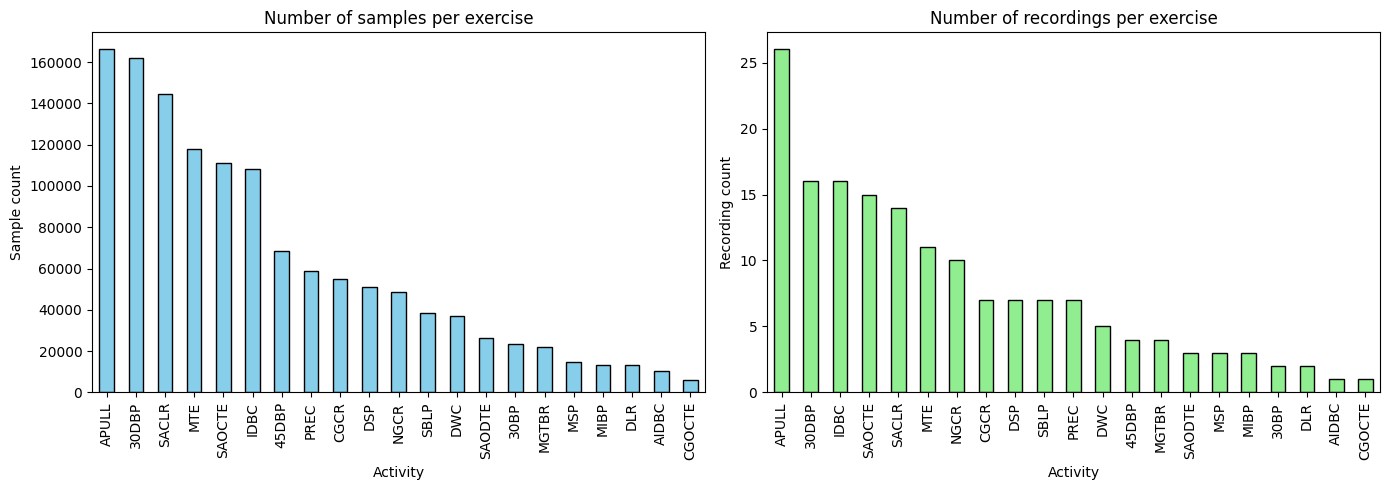

In [ ]:
window_size = 300
step_size = 100

train_loader, test_loader, train_dataset, test_dataset = make_train_test_loaders(
    data=data,
    imu_features=IMU_FEATURES,
    window_size=window_size,
    step_size=step_size,
    train_split=0.8,
    batch_size_train=32,
    batch_size_test=1,
)

print("Train dataset size:", len(train_dataset))
print("Test dataset size:", len(test_dataset))
X0, y0 = train_dataset[0]
print("First sample shape:", X0.shape, "label:", y0.item())

## Cell 4 — Initialize model and optimization
This cell selects device, builds the CNN+LSTM model, computes class weights from training data, and creates loss/optimizer/scheduler.
It sets all objects required for training.

In [ ]:
device = get_device()
num_features = len(IMU_FEATURES)
num_classes = len(activity_to_id)

model = CNNLSTM(
    num_features=num_features,
    num_classes=num_classes,
    hidden_dim=64,
    lstm_layers=2,
).to(device)

class_weights = compute_class_weights(
    train_dataset=train_dataset,
    num_classes=num_classes,
    device=device,
 )

criterion, optimizer, scheduler = build_training_objects(
    model=model,
    class_weights=class_weights,
    learning_rate=2e-4,
    num_epochs=50,
 )

## Cell 5 — Train the model
This cell runs the training loop with validation, gradient clipping, LR scheduling, and early stopping.
The best checkpoint is saved as `best_model_CNN+LSTM.pt`.

In [ ]:
history = train_model(
    model=model,
    train_loader=train_loader,
    test_loader=test_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    num_epochs=50,
    clip_grad_norm=1.0,
    patience=7,
    best_model_path="best_model_CNN+LSTM.pt",
)

print("Training complete.")
print("Best model saved to best_model_CNN+LSTM.pt")

## Cell 6 — Evaluate and report results
This cell evaluates on the test loader, plots the confusion matrix, and prints the classification report with class names.
Use this to inspect final model performance by class.

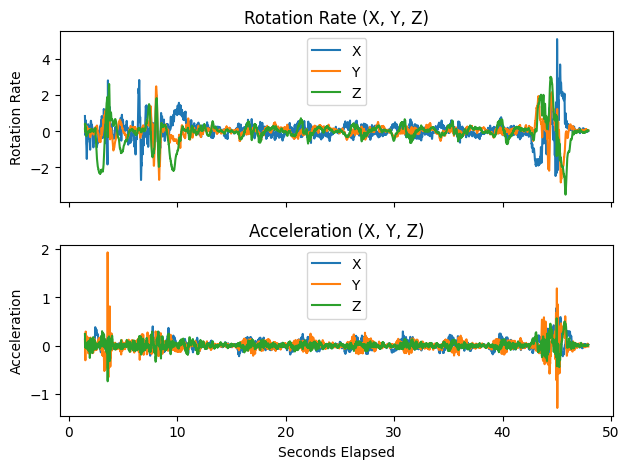

In [ ]:
y_true, y_pred, cm = evaluate_model(model, test_loader, device)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues", xticks_rotation=90)
plt.show()

id_to_activity = {idx: activity for activity, idx in activity_to_id.items()}
report = build_classification_report(y_true, y_pred, id_to_activity)
print(report)

# Exercise Recognition (Modular Pipeline)
This notebook now orchestrates the workflow using external modules:
- data loading/preprocessing in `data_pipeline.py`
- model in `model_architecture.py`
- training and evaluation in `train_eval.py`